# Notebook : 01_data_exploration.ipynb (structure JSON via code)
# 1 - Importation
## 1.1 - Librairies

In [2]:
# notebooks/01_data_exploration.ipynb

# 🔧 Librairies de base
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import sys
from pathlib import Path
import shutil

# 🖼️ Traitement d'images
import cv2
from PIL import Image
import albumentations as A

# 📚 Deep Learning
import tensorflow as tf
from tensorflow.python.client import device_lib
from tensorflow import keras
from keras.utils import img_to_array, load_img
from keras.models import Model
from keras.layers import Input

# 📊 Évaluation / Modèles
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# 🧪 Tests éventuels
import pytest

# GPU
import GPUtil

# 🌱 Environnement
from dotenv import load_dotenv
load_dotenv()

# (optionnel, selon tracking)
import mlflow

# Ajout du chemin pour accéder aux modules
import sys
sys.path.append(str(Path("..") / "src"))

## 1.2 - GPU - Détection & Allocation mémoire dynamique

In [3]:
print("\n🧠 Interpréteur actif :", sys.executable)
print("📦 TensorFlow version :", tf.__version__)

gpus = tf.config.list_physical_devices('GPU')

if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"✅ GPU détecté : {gpus}")
        print("🧪 Détails GPU :", device_lib.list_local_devices())
    except RuntimeError as e:
        print(f"⚠️ Erreur allocation GPU : {e}")
else:
    print("❌ Aucun GPU détecté. Exécution sur CPU.")


🧠 Interpréteur actif : c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P08\P08_segmentation\venv_p8\Scripts\python.exe
📦 TensorFlow version : 2.10.1
✅ GPU détecté : [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
🧪 Détails GPU : [name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13914145400022604292
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4243886080
locality {
  bus_id: 1
  links {
  }
}
incarnation: 18203348174922344753
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1060 6GB, pci bus id: 0000:06:00.0, compute capability: 6.1"
xla_global_id: 416903419
]


In [4]:
GPUtil.showUtilization()

| ID | GPU | MEM |
------------------
|  0 |  4% | 96% |


In [5]:
# Bloc visuel de disponibilité - TensorBoard GPU
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17273431582068507552
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4243886080
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15150439949825737788
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1060 6GB, pci bus id: 0000:06:00.0, compute capability: 6.1"
xla_global_id: 416903419
]


## 1.3 - Configuration des chemins et environnement
- Chemins relatifs depuis notebooks/, vers data/ à la racine du projet

In [6]:
project_root = Path(".." ).resolve()
src_path = project_root / "src"

if str(src_path) not in sys.path:
    sys.path.append(str(src_path))
    
data_dir = project_root / "data"
raw_dir = data_dir / "raw"
processed_dir = data_dir / "processed"
models_dir = project_root / "models"
outputs_dir = project_root / "outputs"
scripts_dir = project_root / "scripts"

image_dir = raw_dir / "images"
mask_dir = raw_dir / "masks"
augmented_dir = raw_dir / "augmented"

train_path = processed_dir / "augmented" / "train.npz"
val_path   = processed_dir / "augmented" / "val.npz"
test_path  = processed_dir / "augmented" / "test.npz"

figures_dir = outputs_dir / "figures"
figures_dir.mkdir(parents=True, exist_ok=True)

IMG_SIZE = (256, 256)
ALPHA_OVERLAY = 0.6

## 1.4 - Extraction d'un échantillon d'images et masques depuis Cityscapes

In [7]:
cityscapes_img_dir = data_dir / "P8_Cityscapes_leftImg8bit_trainvaltest" / "leftImg8bit" / "train"
cityscapes_mask_dir = data_dir / "P8_Cityscapes_gtFine_trainvaltest" / "gtFine" / "train"

image_dir.mkdir(parents=True, exist_ok=True)
mask_dir.mkdir(parents=True, exist_ok=True)

nb_copies = 0
copied_pairs = []

for city in os.listdir(cityscapes_img_dir):
    img_files = list((cityscapes_img_dir / city).glob("*_leftImg8bit.png"))
    for img_path in img_files:
        base = img_path.name.replace("_leftImg8bit.png", "")
        mask_path = cityscapes_mask_dir / city / f"{base}_gtFine_labelIds.png"
        if mask_path.exists():
            img_dest = image_dir / f"{base}.png"
            mask_dest = mask_dir / f"{base}.png"

            shutil.copy(img_path, img_dest)
            shutil.copy(mask_path, mask_dest)

            # Ajout chemin relatif (par rapport au projet)
            copied_pairs.append((
                img_dest.relative_to(project_root),
                mask_dest.relative_to(project_root)
            ))

            nb_copies += 1

print(f"✅ {nb_copies} paires image + mask copiées avec succès.")
print("🗂️ Aperçu des chemins copiés (relatifs) :")
for img_path, mask_path in copied_pairs[:10]:  # n’affiche que les 10 premiers
    print(f"   📷 {img_path}  🎭 {mask_path}")

KeyboardInterrupt: 

## 1.4 - Imports internes

In [8]:
from data_preprocessing.class_mapping import FLAT_CLASS_MAPPING, CLASS_NAME_MAPPING
from data_preprocessing.preprocessing import prepare_dataset
from data_generator.generator import AlbumentationDataGenerator
from utils.viz_utils import plot_class_legend, get_custom_colormap, show_image_mask_grid_overlay, plot_filtered_image_mask_grid, plot_raw_images_grid

## 1.5 - Vérification du contenu

In [9]:
image_list = sorted(os.listdir(image_dir))
mask_list = sorted(os.listdir(mask_dir))

print(f"Nombre d'images: {len(image_list)}\nNombre de masques: {len(mask_list)}")

for i in range(len(image_list)):
    assert image_list[i] == mask_list[i]
    
print(image_list[2], mask_list[2])

sample_mask_path = mask_dir / mask_list[2]
raw_mask = cv2.imread(str(sample_mask_path), cv2.IMREAD_GRAYSCALE)

print(f"\n🌟 Fichier mask brut inspecté : {sample_mask_path.name}")
print("✅ Valeurs uniques dans le mask brut :", np.unique(raw_mask))

remapped_mask = np.full_like(raw_mask, fill_value=255)

for src_id, class_id in FLAT_CLASS_MAPPING.items():
    remapped_mask[raw_mask == src_id] = class_id
    
print("🎨 Valeurs après mapping :", np.unique(remapped_mask))

Nombre d'images: 2975
Nombre de masques: 2975
aachen_000002_000019.png aachen_000002_000019.png

🌟 Fichier mask brut inspecté : aachen_000002_000019.png
✅ Valeurs uniques dans le mask brut : [ 0  1  3  4  5  6  7  8 11 13 17 19 20 21 22 23 24 26 33]
🎨 Valeurs après mapping : [0 1 2 3 4 5 6 7]


In [10]:
from pathlib import Path

# Dossiers Cityscapes d'origine
img_src_dir = data_dir / "P8_Cityscapes_leftImg8bit_trainvaltest" / "leftImg8bit" / "train"
mask_src_dir = data_dir / "P8_Cityscapes_gtFine_trainvaltest" / "gtFine" / "train"

# 1. Récupérer tous les chemins d'images/masks
image_paths = list(img_src_dir.glob("*/*.png"))
mask_paths  = list(mask_src_dir.glob("*/*_gtFine_labelIds.png"))

# 2. Créer des sets de noms de base
img_basenames = set([p.name.replace("_leftImg8bit.png", "") for p in image_paths if "_leftImg8bit.png" in p.name])
mask_basenames = set([p.name.replace("_gtFine_labelIds.png", "") for p in mask_paths])

# 3. Intersection : ce sont les paires valides images+masques
valid_basenames = img_basenames.intersection(mask_basenames)

print(f"📷 Total images (leftImg8bit): {len(img_basenames)}")
print(f"🎭 Total masques (labelIds) : {len(mask_basenames)}")
print(f"✅ Paires image+mask valides : {len(valid_basenames)}")

📷 Total images (leftImg8bit): 2975
🎭 Total masques (labelIds) : 2975
✅ Paires image+mask valides : 2975


In [11]:
missing_masks = img_basenames - mask_basenames
missing_images = mask_basenames - img_basenames

print(f"❌ Images sans masque : {len(missing_masks)}")
print(f"❌ Masques sans image : {len(missing_images)}")

if not missing_masks and not missing_images:
    print("✅ Toutes les images ont leur masque et vice versa !")

❌ Images sans masque : 0
❌ Masques sans image : 0
✅ Toutes les images ont leur masque et vice versa !


## 1.6 - Visualisation de l'arborescence du projet

In [12]:
def display_tree(start_path = '.', max_level = 2, prefix = ''):
    start_path = Path(start_path)
    if max_level < 0:
        return
    for path in sorted(start_path.iterdir()):
        if path.name.startswith('.'):
            continue  # ignore fichiers cachés
        print(f"{prefix}├── {path.name}")
        if path.is_dir():
            display_tree(path, max_level - 1, prefix + "│   ")

In [17]:
display_tree("..", max_level = 2)

├── activate_tf_gpu_env.bat
├── api
│   ├── inference.py
│   ├── main.py
│   ├── model_loader.py
├── app
│   ├── gradio_ui.py
├── check_cuda_config.py
├── data
│   ├── P8_Cityscapes_gtFine_trainvaltest
│   │   ├── gtFine
│   │   ├── license.txt
│   │   ├── README
│   ├── P8_Cityscapes_leftImg8bit_trainvaltest
│   │   ├── leftImg8bit
│   │   ├── license.txt
│   │   ├── README
│   ├── processed
│   │   ├── augmented
│   ├── raw
│   │   ├── images
│   │   ├── masks
├── models
├── notebooks
│   ├── 01_data_exploration.ipynb
│   ├── 02_model_training_unet.ipynb
│   ├── 03_model_transfer_learning.ipynb
│   ├── 04_evaluation_and_metrics.ipynb
│   ├── mlruns
│   │   ├── 0
│   │   ├── models
│   ├── models
│   │   ├── unet_efficientnetb0_256x256_bs4_ep40.h5
│   │   ├── unet_efficientnetb0_256x256_bs4_ep40_history.csv
│   │   ├── unet_efficientnetb0_256x256_bs4_ep40_history.pkl
│   │   ├── unet_efficientnetb0_256x256_bs4_ep40_savedmodel
│   │   ├── unet_efficientnetb0_256x256_bs4_ep40_training_p

## 1.7 - Mapping des classes

In [13]:
print("📜 Mapping des classes (ID → Nom) :\n")
for class_id, class_name in CLASS_NAME_MAPPING.items():
    print(f"  Classe {class_id} : {class_name}")

📜 Mapping des classes (ID → Nom) :

  Classe 0 : void
  Classe 1 : flat
  Classe 2 : construction
  Classe 3 : object
  Classe 4 : nature
  Classe 5 : sky
  Classe 6 : human
  Classe 7 : vehicle


# 2 - Chargement des fichiers .npz (prétraités)

In [14]:
if not (train_path.exists() and val_path.exists() and test_path.exists()):
    print("[INFO] Fichiers .npz absents. Lancement du preprocessing.")
    prepare_dataset(
        image_dir = image_dir,
        mask_dir  = mask_dir,
        output_dir = processed_dir / "augmented",
        mapping_dict = FLAT_CLASS_MAPPING,
        img_size = IMG_SIZE,
        force_preprocessing = True,
        mlflow_tracking = True
    )
else:
    print("[INFO] Fichiers .npz déjà présents. Pas de preprocessing nécessaire.")

[INFO] Fichiers .npz absents. Lancement du preprocessing.
[LOG] ➤ prepare_dataset appelé


100%|██████████| 2975/2975 [02:05<00:00, 23.79it/s]


[LOG] Infos de preprocessing ajoutées à : outputs\logs\preprocessing_log.csv
[FIG] Graphe de distribution sauvegardé dans : outputs\figures\class_distribution_augmented.png
[✅] Preprocessing terminé. Données sauvegardées dans : C:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P08\P08_segmentation\data\processed\augmented


In [15]:
train = np.load(train_path)
val = np.load(val_path)
test = np.load(test_path)
X_train, y_train = train["X"], train["Y"]
X_val, y_val     = val["X"], val["Y"]
X_test, y_test   = test["X"], test["Y"]

# 3 - Aperçu de l'augmentation avec Albumentations (via DataGenerator)

In [16]:
preview_generator = AlbumentationDataGenerator(
    image_dir = image_dir,
    mask_dir = mask_dir,
    batch_size = 4,
    img_size = IMG_SIZE,
    augment = True,
    shuffle = True
)

In [17]:
X_batch, y_batch = preview_generator[0]

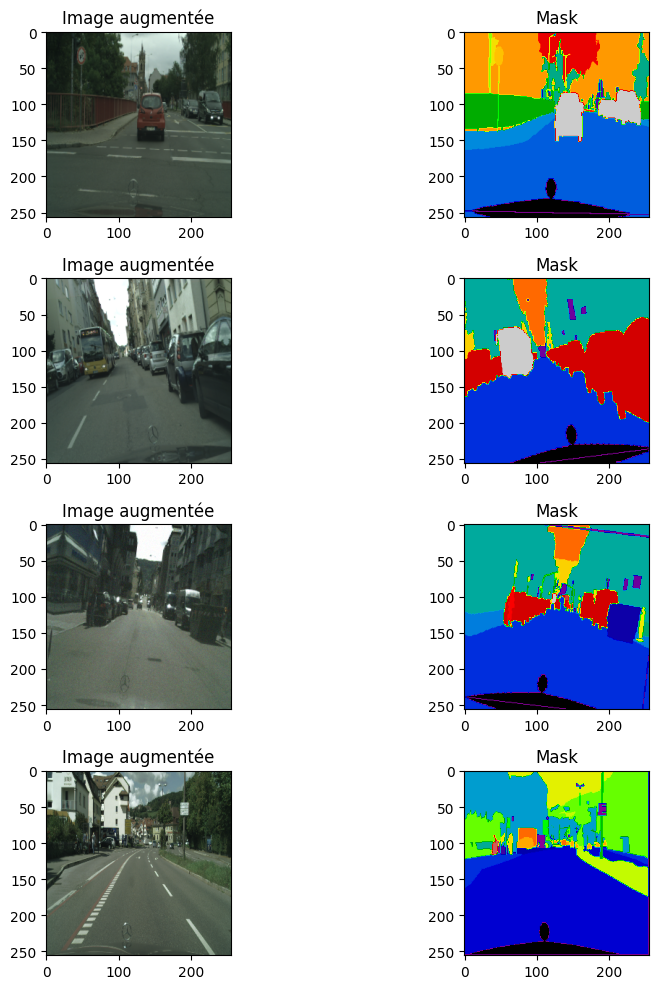

In [18]:
fig, axes = plt.subplots(4, 2, figsize=(10, 10))

for i in range(4):
    axes[i, 0].imshow(X_batch[i])
    axes[i, 0].set_title("Image augmentée")
    axes[i, 1].imshow(y_batch[i], cmap = 'nipy_spectral')
    axes[i, 1].set_title("Mask")

plt.tight_layout()
plt.savefig(outputs_dir / "figures" / "preview_generator_overlay.png")
plt.show()

# 4 - Statistiques des données

In [19]:
print("[INFO] Taille des images :", X_train.shape[1:])
print("[INFO] Taille des masks  :", y_train.shape[1:])
print("[INFO] Nombre d'images d'entraînement :", X_train.shape[0])

[INFO] Taille des images : (256, 256, 3)
[INFO] Taille des masks  : (256, 256)
[INFO] Nombre d'images d'entraînement : 2380


In [20]:
unique_labels = np.unique(y_train)
print("[INFO] Labels uniques dans y_train :", unique_labels)

[INFO] Labels uniques dans y_train : [0 1 2 3 4 5 6 7]


[IMG] Images brutes sauvegardées dans : C:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P08\P08_segmentation\outputs\figures\raw_train_images.png


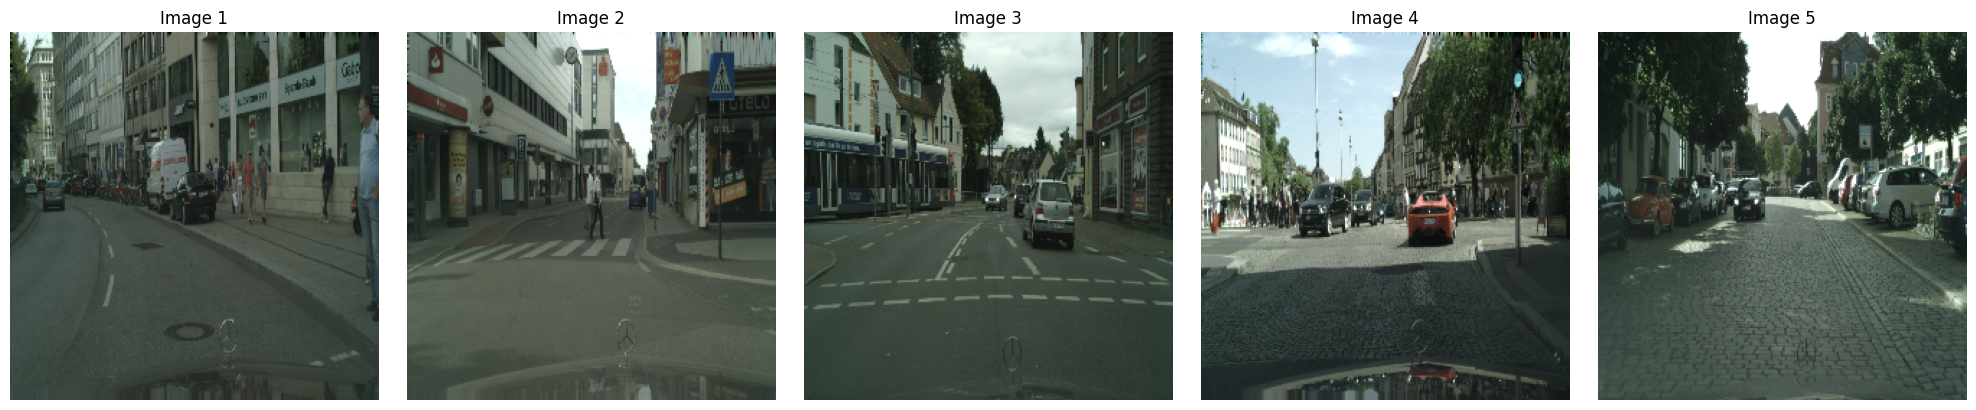

In [21]:
plot_raw_images_grid(
    X_train,
    save_path=outputs_dir / "figures" / "raw_train_images.png",
    n=5
)

# 5 - Distribution des classes + légende

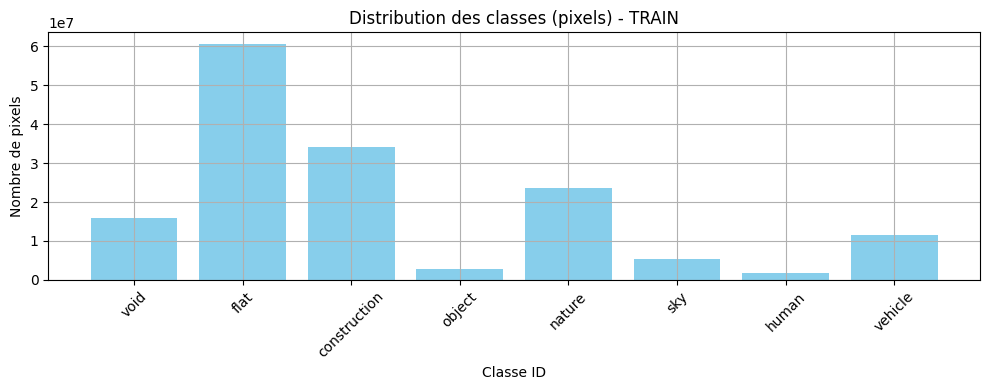

In [22]:
flat = y_train.flatten()
class_counts = np.bincount(flat[flat != 255], minlength = len(CLASS_NAME_MAPPING))

plt.figure(figsize=(10, 4))
plt.bar(range(len(class_counts)), class_counts, color = "skyblue")
plt.title("Distribution des classes (pixels) - TRAIN")
plt.xlabel("Classe ID")
plt.ylabel("Nombre de pixels")
plt.xticks(range(len(CLASS_NAME_MAPPING)), list(CLASS_NAME_MAPPING.values()), rotation = 45)
plt.grid(True)
plt.tight_layout()
plt.savefig(outputs_dir / "figures" / "class_distribution_train.png")
plt.show()

# 6 - Visualisation superposée (overlay masks)

[FIG] Figure filtrée sauvegardée dans : C:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P08\P08_segmentation\outputs\figures\train_overlay_preview_filtered.png


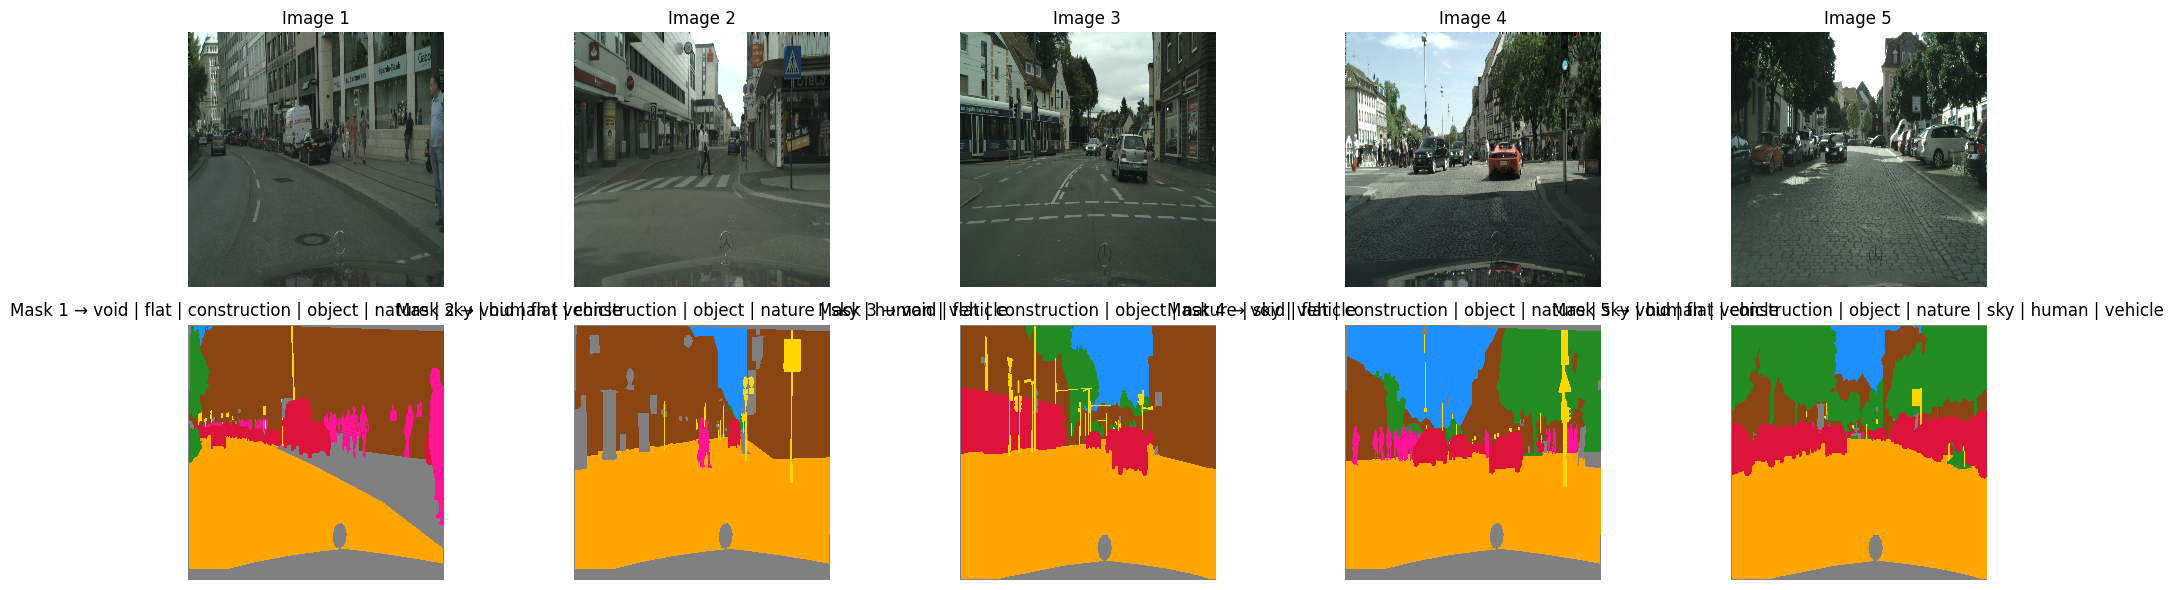

In [23]:
plot_filtered_image_mask_grid(
    X_train,
    y_train,
    class_mapping=CLASS_NAME_MAPPING,
    save_path=outputs_dir / "figures" / "train_overlay_preview_filtered.png",
    n=5,
    alpha=ALPHA_OVERLAY
)

c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P08\P08_segmentation\notebooks\..\src\utils\viz_utils.py:118: UserWarning: Glyph 127912 (\N{ARTIST PALETTE}) missing from current font.
  plt.tight_layout()
c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P08\P08_segmentation\venv_p8\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127912 (\N{ARTIST PALETTE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


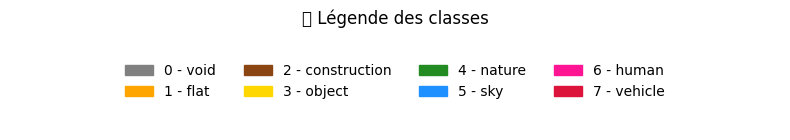

In [24]:
plot_class_legend()

# 7 - Comparaison train/val/test

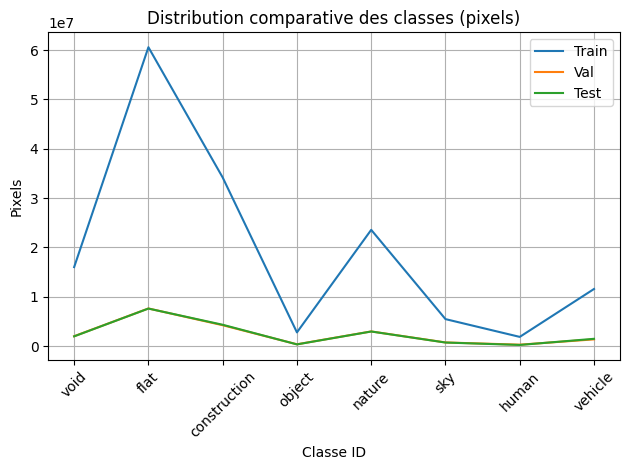

In [25]:
for label_set, name in zip([y_train, y_val, y_test], ["Train", "Val", "Test"]):
    flat = label_set.flatten()
    counts = np.bincount(flat[flat != 255], minlength=len(CLASS_NAME_MAPPING))
    plt.plot(range(len(counts)), counts, label=name)
    
plt.title("Distribution comparative des classes (pixels)")
plt.xlabel("Classe ID")
plt.ylabel("Pixels")
plt.xticks(range(len(CLASS_NAME_MAPPING)), list(CLASS_NAME_MAPPING.values()), rotation = 45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(outputs_dir / "figures" / "class_distribution_comparison.png")
plt.show()

In [26]:
print(train_path.exists(), val_path.exists(), test_path.exists())


True True True


In [27]:
train = np.load(train_path)
print(train.files)
print(train['X'].shape, train['Y'].shape)


['X', 'Y']
(2380, 256, 256, 3) (2380, 256, 256)
